# MLP on MINST Dataset

In [1]:
Pkg.update()
Pkg.add("MNIST")
using PyPlot

INFO: Updating METADATA...
INFO: Updating cache of PDMats...
INFO: Computing changes...
INFO: Upgrading Conda: v0.3.2 => v0.4.0
INFO: Upgrading PDMats: v0.5.0 => v0.5.1
INFO: Building Conda
INFO: Nothing to be done


In [33]:
using MNIST
function mnistData()
    features = trainfeatures(1)
    label = trainlabel(1)

    trainX, trainY = traindata()
    N = size(trainX)[2]
    idx = randperm(N)
    trainX = trainX[:, idx]'
    trainY = trainY[idx]

    testX, testY = testdata()
    N = size(testX)[1]
    idx = randperm(N)
    testX = testX[:, idx]'
    testY = testY[idx]

    ttl = 5000
    trX, trY = trainX[1:ttl,:], trainY[1:ttl,:]

    @assert size(trX)[1] == size(trY)[1]
    println(size(trX), size(trY))

    trX = trX / 256. 
    return trX, trY
end
trainX, trainY = mnistData()


(5000,784)(5000,1)


(5000,784)

In [44]:
include("layers/CrossEntropy.jl")
include("layers/SquareLossLayer.jl")
include("layers/FCLayer.jl")
include("layers/DropoutLayer.jl")
include("layers/ReLu.jl")
include("layers/Tanh.jl")
include("layers/SequnetialNet.jl")

([2.40761,1.31818],[2,1])
[0.244728 -0.909969 0.665241; 0.00490169 0.727475 -0.732377]


Diff: [0.0; 0.0; 2.0; 5.0]
(
[14.5],

[-1; 1; 1; 1])
dldy:[0.0; 0.0; 2.0; 5.0]
[0.0; 0.0; 2.0; 5.0]


FCLayer(2,[1.00211 1.43892 -6.17671; -2.57508 -3.7613 -0.637501; 0.0 0.0 0.0],[0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0])
[3.0 22.0 21.0; 7.0 46.0 45.0]
[56.0 110.0; 74.0 144.0]
[26.0 30.0 34.0; 38.0 44.0 50.0; 12.0 14.0 16.0]


[1.0 2.0; 0.0 3.0; 1.0 0.0; 0.0 0.0]
[2.0 3.0; 0.0 5.0; 3.0 0.0; 0.0 0.0]


[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]
[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


backward (generic function with 7 methods)

In [9]:
size(trainX), size(trainY)
i = convert(Int, ceil(rand() * size(trainX)[1]))

31

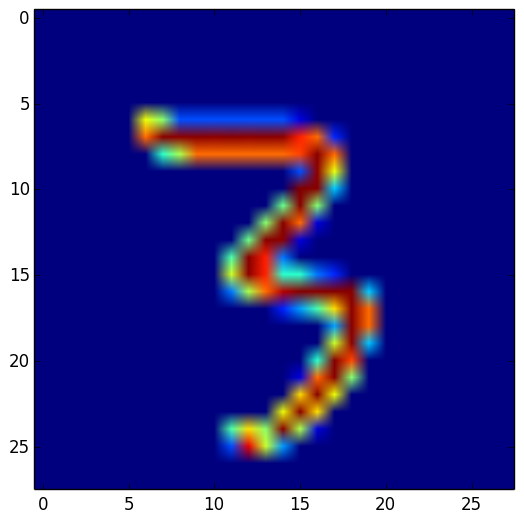

3.0

In [22]:
i = convert(Int, ceil(rand() * size(trainX)[1]))
x =reshape(trainX[i,:], 28,28) ./ 256
imshow(x)



In [40]:
function train(net::SequentialNet, X, Y; batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        println("Epo $(epo) num batches : $(num_batch)")
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * gradient(layer) / batch_size
                local veloc = getLDiff(layer) * alpha - gradi
                local theta = getParam(layer) + alpha * veloc - gradi
                if verbose > 1
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size

            if verbose > 0
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
    end
    return (epo_losses,epo_accu)
end

train (generic function with 1 method)

In [36]:

function build_mlp_without_dropout()
    layers = [
        FCLayer(784, 800),
        ReLu(),
        FCLayer(800, 10)
    ]
    criteria = CrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end


build_mlp_without_dropout (generic function with 1 method)

In [34]:
size(trainX)

(5000,784)

In [49]:
net = build_mlp_without_dropout()

losses,accus = train(net, trainX, trainY, ttl_epo = 100; batch_size = 10,
               lrSchedule = x -> 0.05, verbose=0, alpha=0.9)
subplot(121)
plot(1:length(losses), losses)
title("Epoch Losses")

subplot(122)
plot(1:length(accus), accus)
title("Epoch Accuracy")
show()


Epo 1 num batches : 500.0
Epo 1 has loss :1.9710906630398939		accuracy : 0.1984
Epo 2 num batches : 500.0
Epo 2 has loss :1.7576747869233436		accuracy : 0.2286
Epo 3 num batches : 500.0
Epo 3 has loss :1.5158325576721787		accuracy : 0.2192
Epo 4 num batches : 500.0
Epo 4 has loss :1.489937909607065		accuracy : 0.2442
Epo 5 num batches : 500.0
Epo 5 has loss :1.4685077159976399		accuracy : 0.2428
Epo 6 num batches : 500.0
Epo 6 has loss :1.472260833932817		accuracy : 0.2328
Epo 7 num batches : 500.0
Epo 7 has loss :1.4014105587608432		accuracy : 0.2366
Epo 8 num batches : 500.0
Epo 8 has loss :1.4378701007036		accuracy : 0.2328
Epo 9 num batches : 500.0
Epo 9 has loss :1.5203730186720024		accuracy : 0.2372
Epo 10 num batches : 500.0
Epo 10 has loss :1.4586925137822475		accuracy : 0.2536
Epo 11 num batches : 500.0
Epo 11 has loss :1.2616428206273056		accuracy : 0.2516
Epo 12 num batches : 500.0
Epo 12 has loss :1.1113216942416955		accuracy : 0.2556
Epo 13 num batches : 500.0
Epo 13 has l

LoadError: LoadError: InterruptException:
while loading In[49], in expression starting on line 3